# PCA on neuronal features made of tuning indices

In [87]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib


# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.12.1+cu102
Using device: cuda:0


## Loading tuning curve data

In [88]:
def load_tc_data(datadir, mouse_id, session_id, subset, phase='wake'):
    data = np.load(datadir + f'{mouse_id}_{session_id}_{phase}_{subset}.npz')
    tc_rates = data['tuning_curves_rates']  # (neurons, num_cov, steps)
    tc_FF = data['tuning_curves_FF']  # (neurons, num_cov, steps)
    tc_cov = data['tuning_curves_covariates']  # (num_cov, steps)
    
    return tc_rates, tc_FF, tc_cov

In [89]:
def tuning_index(hd_stat):
    """Compute the tuning index of a tuning curve with a given statistics of spike count distributions."""
    tc_max = np.max(hd_stat, axis=-1)
    tc_min = np.min(hd_stat, axis=-1)

    return (tc_max - tc_min) / (tc_max + tc_min)

In [101]:
datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/tc_data/'

phase='wake'

mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129']
} 

subset='hdc'
mouse_id = 'Mouse24'
session_id = '131213'

num_hdc = {}
num_nonhdc = {}
features_rates = np.empty((0, 6))  # we have 6 covariates, so 6 features
features_FF = np.empty((0, 6))
for mouse_id in mice_sessions.keys():
    num_hdc[mouse_id] = {}
    num_nonhdc[mouse_id] = {}
    for session_id in mice_sessions[mouse_id]:
        for subset in ['hdc', 'nonhdc']:
            tc_rates, tc_FF, tc_cov = load_tc_data(datadir, mouse_id, session_id, subset)
            ti_rates = tuning_index(tc_rates)  # (neurons, num_cov)
            ti_FF = tuning_index(tc_FF)
            
            if subset == 'hdc':
                num_hdc[mouse_id][session_id] = ti_rates.shape[0]
            else:
                num_nonhdc[mouse_id][session_id] = ti_rates.shape[0]
                
            features_rates = np.concatenate((features_rates, ti_rates), axis=0)
            features_FF = np.concatenate((features_FF, ti_FF), axis=0)


## PCA on rate features

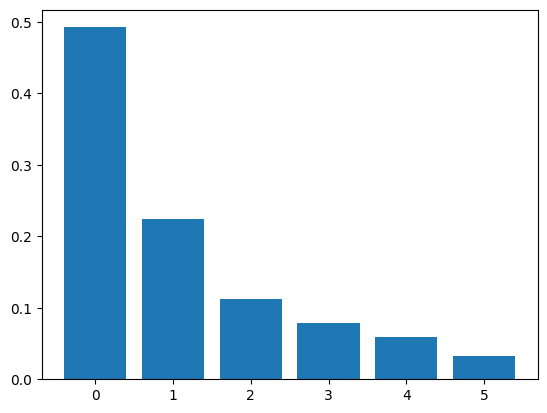

In [102]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(features_rates)
var_explained = pca.explained_variance_ratio_

plt.bar(np.arange(len(var_explained)), var_explained)

components = pca.transform(features_rates)

In [103]:
def plot_pca_hdc_nonhdc(components, filter_hdc):
    fig, ax = plt.subplots()
    ax.scatter(components[filter_hdc, 0], components[filter_hdc, 1], c='r', label='hd neurons')
    ax.scatter(components[np.invert(filter_hdc), 0], components[np.invert(filter_hdc), 1], c='b', label='non-hd neurons')
    ax.set_title('First 2 principal components of neuronal features')
    ax.legend()
    ax.grid()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(components[filter_hdc, 0], components[filter_hdc, 1], components[filter_hdc, 2], 
               c='r', label='hd neurons')
    ax.scatter(components[np.invert(filter_hdc), 0], components[np.invert(filter_hdc), 1], components[np.invert(filter_hdc), 2], 
               c='b', label='non-hd neurons')
    ax.set_xlabel('1st PC')
    ax.set_ylabel('2nd PC')
    ax.set_zlabel('3rd PC')
    ax.set_title('First 3 principal components of neuronal features')
    ax.legend()

In [104]:
def plot_pca_diff_mice(components, mice_sessions, num_hdc, num_nonhdc):
    num_neurons_per_mice = []
    for mouse_id in mice_sessions.keys():
        num = 0
        for session_id in mice_sessions[mouse_id]:
            num += num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id]
        num_neurons_per_mice.append(num)

    cum_neurons = np.cumsum(np.array(num_neurons_per_mice))
    cum_neurons = np.insert(cum_neurons, 0, 0)

    # define the colormap
    colors = list(matplotlib.colors.BASE_COLORS)

    fig, ax = plt.subplots()
    for i, mouse_id in enumerate(mice_sessions.keys()):
            ax.scatter(components[cum_neurons[i]:cum_neurons[i+1], 0], components[cum_neurons[i]:cum_neurons[i+1], 1], c=colors[i], label=mouse_id)
    ax.set_title('First 2 principal components of neuronal features')
    ax.legend()
    ax.grid()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for i, mouse_id in enumerate(mice_sessions.keys()):
            ax.scatter(components[cum_neurons[i]:cum_neurons[i+1], 0], components[cum_neurons[i]:cum_neurons[i+1], 1], components[cum_neurons[i]:cum_neurons[i+1], 2], c=colors[i], label=mouse_id)
    ax.set_xlabel('1st PC')
    ax.set_ylabel('2nd PC')
    ax.set_zlabel('3rd PC')
    ax.set_title('First 3 principal components of neuronal features')
    ax.legend()

## Plot hdc vs non-hdc

In [105]:
labels_hdc = []

for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        labels_hdc += [1]*num_hdc[mouse_id][session_id] + [0]*num_nonhdc[mouse_id][session_id]

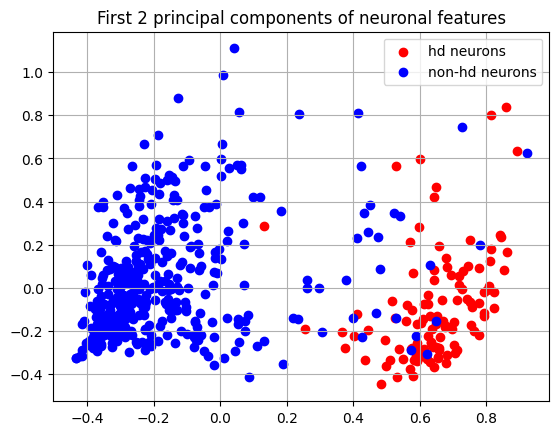

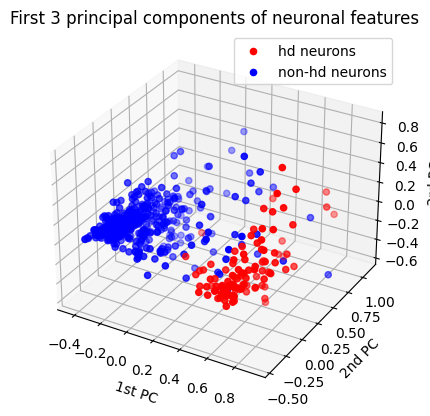

In [106]:
filter_hdc = np.array(labels_hdc).astype(bool)

plot_pca_hdc_nonhdc(components, filter_hdc)


## Plot neurons from different mice

In [107]:
labels_mice = []

for i, mouse_id in enumerate(mice_sessions.keys()):
    for session_id in mice_sessions[mouse_id]:
        labels_mice += [i]*(num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id])

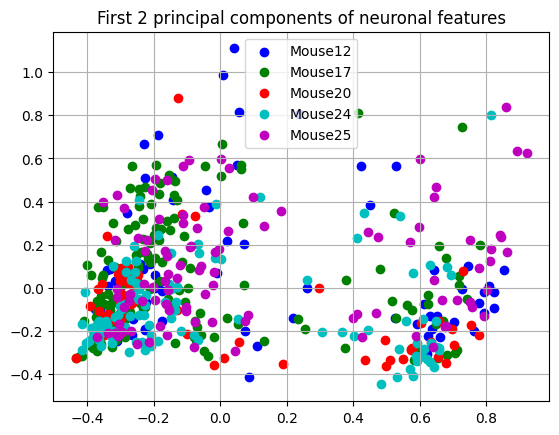

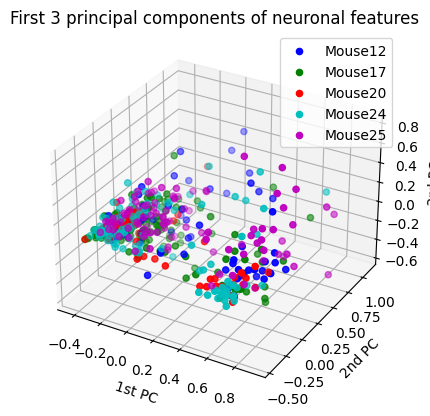

In [108]:
plot_pca_diff_mice(components, mice_sessions, num_hdc, num_nonhdc)

## PCA on Fano Factor features

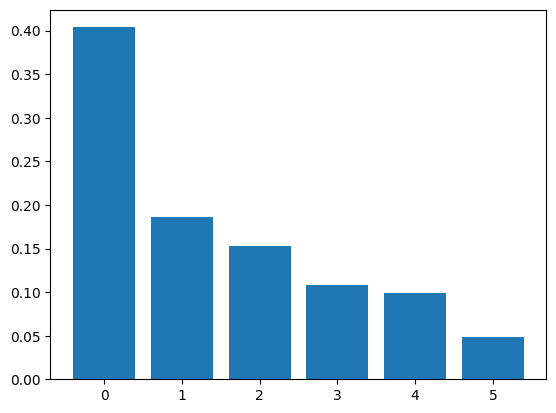

In [109]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(features_FF)
var_explained = pca.explained_variance_ratio_

plt.bar(np.arange(len(var_explained)), var_explained)


components = pca.fit_transform(features_FF)

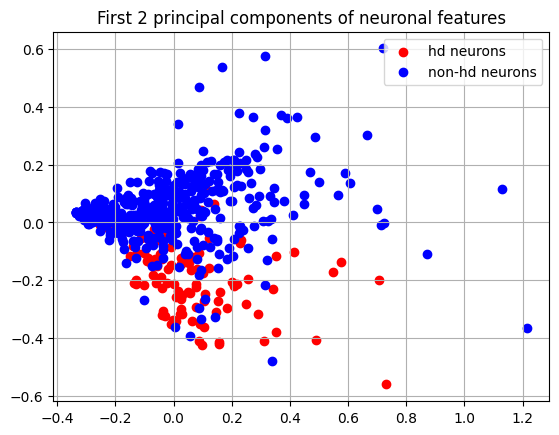

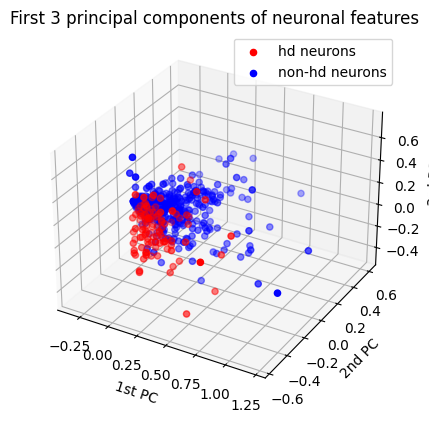

In [110]:
filter_hdc = np.array(labels_hdc).astype(bool)

plot_pca_hdc_nonhdc(components, filter_hdc)


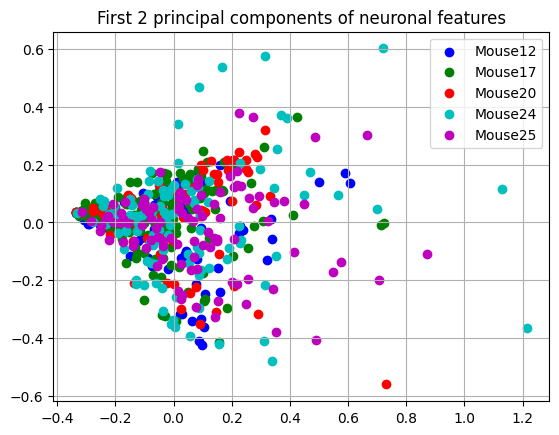

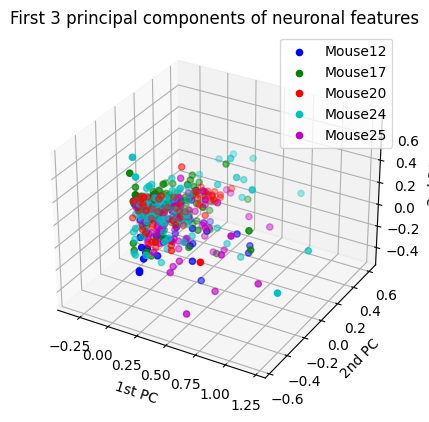

In [111]:
plot_pca_diff_mice(components, mice_sessions, num_hdc, num_nonhdc)